In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
from IPython import display

In [4]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        print(progress)
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [5]:
WIDTH = 128
HEIGHT = 128
BATCH_SIZE = 12

import pathlib
data_path = os.getcwd() + "\\Data\\Faces_reduced"
data_dir = pathlib.Path(data_path)

def preprocess(img):
    return (img-127.5)/127.5


In [6]:
def load_data():
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess)
    train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(HEIGHT, WIDTH)
                                                )
    return train_data_gen

In [7]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow((image_batch[n]+1)/2)
      plt.axis('off')


Found 3929 images belonging to 1 classes.


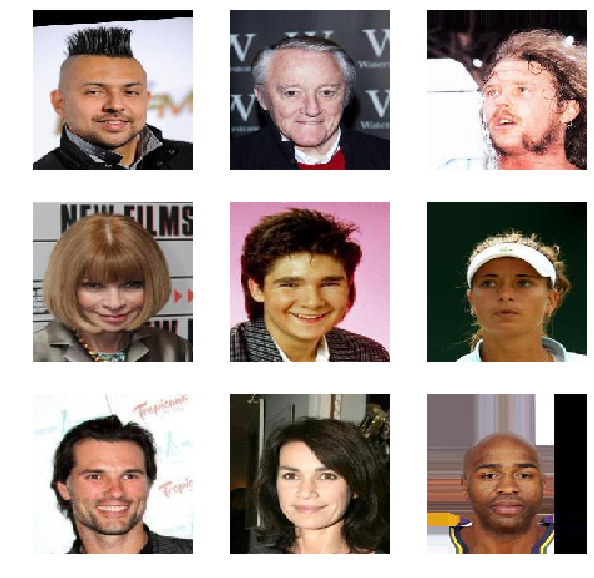

In [8]:
train_data_gen = load_data()
image_batch, label_batch = train_data_gen[0]
show_batch(image_batch, label_batch)


In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(HEIGHT//4 * WIDTH//4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((HEIGHT//4, WIDTH//4, 256)))
    assert model.output_shape == (None, HEIGHT//4, WIDTH//4, 256), print(model.output_shape) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, HEIGHT//4, WIDTH//4, 128), print(model.output_shape)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, HEIGHT//2, WIDTH//2, 64), print(model.output_shape)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, HEIGHT, WIDTH, 3), print(model.output_shape)

    return model

W0427 15:57:10.628104  7304 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


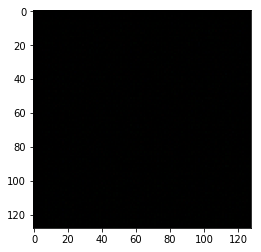

In [46]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np.shape(generated_image)
plt.imshow(generated_image[0, :, :, :])

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[HEIGHT, WIDTH, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [48]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00091193]], shape=(1, 1), dtype=float32)


In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [47]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
checkpoint_dir = './training_checkpoints2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [50]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    epoch_gen_losses = []
    epoch_disc_losses = []
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [ ]:
GenLosses = []
DiscLosses = []

In [51]:

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        idx = np.random.choice(len(dataset), len(dataset))#1000//BATCH_SIZE)
        batch_number = 1
        
        Glosses = []
        Dlosses = []
        
        print(len(dataset))
        for i in idx:
            gen_loss, disc_loss = train_step(dataset[i][0])
            Glosses.append(gen_loss)
            Dlosses.append(disc_loss)
            if epoch ==0:
                update_progress(batch_number/len(dataset))
                batch_number+=1
        
        
        GenLosses.append(np.mean(Glosses))
        DiscLosses.append(np.mean(Dlosses))
        
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [52]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :,:]+1)/2)
        plt.axis('off')
    
    last_epoch = 0
    plt.savefig('images3\\image_at_epoch_{:04d}.png'.format(last_epoch+epoch))
    plt.show()

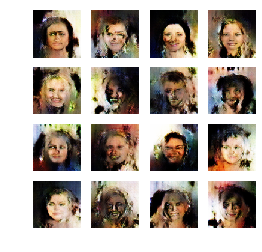

In [55]:
train(train_data_gen, 50)

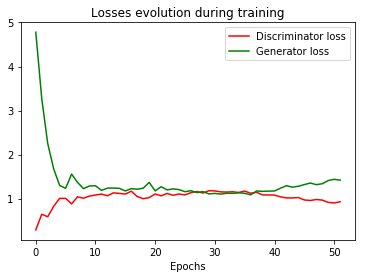

In [61]:
plt.figure
plt.plot(DiscLosses, color = 'red', label = 'Discriminator loss')
plt.plot(GenLosses, color = 'Green', label = 'Generator loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Losses evolution during training')
plt.show()

In [62]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints\\ckpt-4'

In [32]:
checkpoint.restore(tf.train.latest_checkpoint('./training_checkpoints'))

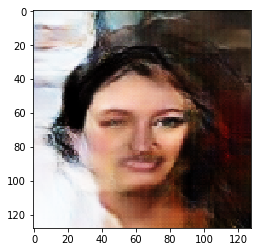

In [34]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow((generated_image[0, :, :, :]+1)/2)

# ACP

In [18]:
X=[]
Y=[]
for i in range(2000):
    noise = tf.random.normal([1, 100])
    X.append(noise.numpy())
    generated_image = generator(noise, training=False)
    realism = discriminator(generated_image, training=False)
    Y.append(float(realism))
X = np.array(X)[:,0,:]

In [94]:
np.shape(X)

(100, 100)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize

In [20]:
def get_components(X,Y,k):
    components = []
    X2 = np.array(X)
    Y2 = np.array(Y)
    for i in range(k):
        reg = LinearRegression(fit_intercept = False)
        reg.fit(np.array(X2),Y2)
        coeffs = reg.coef_
        Y2-=np.dot(X2,coeffs)
        #X2-=coeffs
        
        components.append(coeffs)
    return normalize(components)

In [21]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [22]:
def show(**kwargs):
    k = len(kwargs)
    components = get_components(X,Y,k)
    entry = np.zeros_like(components[0])
    for key, value in kwargs.items():
        entry += components[int(key[1:])]*value
    entry = tf.convert_to_tensor(entry)
    entry = tf.reshape(entry, [-1, 100])
    generated_image = generator(entry, training=False)
    plt.figure(figsize = (10,10))
    plt.imshow((generated_image[0, :, :, :]+1)/2)

In [63]:
def sliders(r):
    k=5*r
    sliderdict = {}
    sliderlist = []
    for i in range(k):
        a = widgets.FloatSlider(value = np.random.randint(-3,3), min = -5,max = 5,step = 1)
        sliderdict['x'+str(i)] = a
        sliderlist.append(a)
        
    box = []
    boxlist = []
    for i in range(k//5):
        boxlist.append(widgets.HBox([sliderlist[idx] for idx in range(5*i,5*(i+1))]))
    
    ui = widgets.VBox(boxlist)
    out = widgets.interactive_output(show, sliderdict)
    display.display(ui, out)

In [65]:
sliders(5) # number of lines of 5 sliders -> 25 sliders

Output()

In [36]:
discriminator.__dict__

{'_self_setattr_tracking': True,
 '_thread_local': <_thread._local at 0x274c2900048>,
 '_name': 'sequential_1',
 '_activity_regularizer': None,
 '_trainable': True,
 '_dynamic': False,
 '_is_compiled': False,
 '_layers': [<tensorflow.python.keras.engine.input_layer.InputLayer at 0x274c21d4e80>,
 '_compute_output_and_mask_jointly': True,
 'supports_masking': False,
 'optimizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_losses': [],
 '_callable_losses': [],
 '_metrics': [],
 '_scope': None,
 '_reuse': None,
 '_graph': None,
 '_dtype_policy': <Policy "float32", loss_scale=None>,
 '_dtype_defaulted_to_floatx': True,
 '_outbound_nodes': [],
 '_inbound_nodes': [<tensorflow.python.keras.engine.node.Node at 0x274c28d5e10>],
 '_trackable_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x274c28d5e48>,
 '_is_graph_network': True,
 '_expects_training_arg': True,
 '_expects_mask_arg': True,
 '_autocast': False,
 '_supports_ragged_inputs